In [10]:
%reset -f
%load_ext autoreload
%autoreload 2

import os
import sys
import pathlib

import numpy as np
from argparse import ArgumentParser

import ROOT as rt
from ROOT import TChain, TCanvas, TH1F, TH2F, TLatex, TGraph, RDataFrame
# from src.candidates import LLPCandidate, DTCandidate, CSCCandidate
from src.histo_utilities import create_prof1D, create_TGraph, create_TH1D, create_TH2D, std_color_list
from src import CMS_lumi, tdrstyle
from src.helper_functions import getRecoTime, find_nearest, deltaPhi, deltaR
import uproot
import awkward as ak

from build_rdf import *
from main import canvas, weight_calc, land, lxor, lor, lnot

out_dir = '/home/psimmerl/Documents/CMS/LLP/reports/weekly/feb12/'
data_dir = '/home/psimmerl/Documents/CMS/LLP/data/raw/'
MC_file = data_dir + 'ggH_HToSSTobbbb_MH-125_MS-15_CTau1000_13p6TeV_1pb_weighted.root'
run3_file = data_dir + 'DisplacedJet-EXOCSCCluster_Run2022EFG-PromptReco-v1_goodLumi.root'

tree_name = 'MuonSystem'
file_in = run3_file
gc = []

pathlib.Path(out_dir).mkdir(parents=True, exist_ok=True)  # make out directory if it doesn't exist

print(f'Processing tree \'{tree_name}\' from \'{file_in}\':')
# rdf = RDataFrame(tree_name, file_in)

a = tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0
met = False

muon_system = uproot.open(file_in + ':' + tree_name)
D = muon_system.arrays()

# max_csc = np.max(D['nCscRechitClusters'])
# max_dt = np.max(D['nDtRechitClusters'])
# print(f'nDt\\nCsc ||'+''.join([f' {nc:7} |' for nc in range(max_csc+1)]))
# print('-'*9+'++'+('-'*9+'+')*(max_csc+1))
# for nd in range(max_dt+1):
#     print(f'{nd:>8} ||', end='')
#     for nc in range(max_csc+1):
#         c = np.sum((D['nCscRechitClusters'] == nc) & (D['nDtRechitClusters'] == nd))
#         # c = np.sum(land(D['nCscRechitClusters'] == nc, D['nDtRechitClusters'] == nd))
#         print(f' {c:>7} |', end='')
#     print('')

print(f'# of Evts = {len(D["weight"]):>10,}')
print(f'# of CSC  = {np.sum(D["nCscRechitClusters"]):>10,}')
print(f'# of DT   = {np.sum(D["nDtRechitClusters"]):>10,}')
print(f'CSC+DT>2  = {np.sum(D["nCscRechitClusters"] + D["nDtRechitClusters"] >= 2):>10,}')


branches = [x.name for x in muon_system.branches]
idx_sig_csc_clusters = D['cscRechitClusterSize'] > 100
idx_sig_dt_clusters = D['dtRechitClusterSize'] > 100

print('Using BOTH regions'); idx_csc, idx_dt = np.ones_like(idx_sig_csc_clusters), np.ones_like(idx_sig_dt_clusters)
# print('Extracting SIGNAL region'); idx_csc, idx_dt = idx_sig_csc_clusters, idx_sig_dt_clusters
# print('Extracting BACKGROUND region'); idx_csc, idx_dt = lnot(idx_sig_csc_clusters), lnot(idx_sig_dt_clusters)
D['nCscRechitClusters'], D['nDtRechitClusters'] = np.sum(idx_csc, axis=1), np.sum(idx_dt, axis=1)

idx_csc_jet = land(D['cscRechitClusterJetVetoLooseId'], D['cscRechitClusterJetVetoPt'] > 50)
idx_dt_jet = land(D['dtRechitClusterJetVetoLooseId'], D['dtRechitClusterJetVetoPt'] > 50)
idx_csc_lep = (D['cscRechitClusterMuonVetoLooseId'])
idx_dt_lep = (D['dtRechitClusterMuonVetoLooseId'])

idx_csc = land(idx_csc, lor(idx_csc_jet, idx_csc_lep))
idx_dt = land(idx_dt, lor(idx_dt_jet, idx_dt_lep))

# idx_ev = land(idx_ev, *[idx_met, idx_jet, idx_lep])
for b in branches:
    if 'cscRechitCluster' in b:
        D[b] = D[b][idx_csc]
    if 'dtRechitCluster' in b:
        D[b] = D[b][idx_dt]
        
D['nCscRechitClusters'], D['nDtRechitClusters'] = np.sum(idx_csc, axis=1), np.sum(idx_dt, axis=1)

print('Applying EVENT LEVEL cuts')
idx_ev = D['nCscRechitClusters'] + D['nDtRechitClusters'] >= 2

idx_met = D['met'] > 200
if met:
    print('APPLYING MET CUT')
    idx_ev = land(idx_met, idx_ev)
D = D[idx_ev]


D['nMuons'] = np.sum(np.abs(D['lepPdgId']) == 13, axis=1)
print(f'# of Evts = {len(D["weight"]):>10,}')
print(f'# of CSC  = {np.sum(D["nCscRechitClusters"]):>10,}')
print(f'# of DT   = {np.sum(D["nDtRechitClusters"]):>10,}')
print(f'CSC+DT>2  = {np.sum(D["nCscRechitClusters"] + D["nDtRechitClusters"] >= 2):>10,}')



# cut_comment = ''
# file_comment = ''
cut_comment = '(Jet Matched & Jet Pt > 50) Or Muon Matched'
file_comment = '_fail_jet_muon_match'
if met:
    cut_comment += ', Missing E_{T} > 200 GeV'
    file_comment += '_MET'
file_comment += '.png'
# print(np.sum(D['nMuons'])/np.sum(D['nLeptons'])) # is 100%

leg = rt.TLegend(0.6, 0.2, 0.9, 0.35)
leg.SetTextSize(0.025)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)

lat = rt.TLatex()
lat.SetTextColor(rt.kRed)
lat.SetTextSize(0.05)
lat.SetTextAlign(33)

rt.gStyle.SetOptFit(1011)



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Processing tree 'MuonSystem' from '/home/psimmerl/Documents/CMS/LLP/data/raw/DisplacedJet-EXOCSCCluster_Run2022EFG-PromptReco-v1_goodLumi.root':
# of Evts =  1,716,981
# of CSC  =  2,979,964
# of DT   =    618,345
CSC+DT>2  =  1,716,981
Using BOTH regions
Applying EVENT LEVEL cuts
# of Evts =     59,082
# of CSC  =    111,875
# of DT   =      7,250
CSC+DT>2  =     59,082


/home/psimmerl/mambaforge/envs/rtenv/lib/python3.10/site-packages/root_numpy/_hist.py:75: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return _librootnumpy.fill_h1(
/home/psimmerl/mambaforge/envs/rtenv/lib/python3.10/site-packages/root_numpy/_hist.py:75: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review 

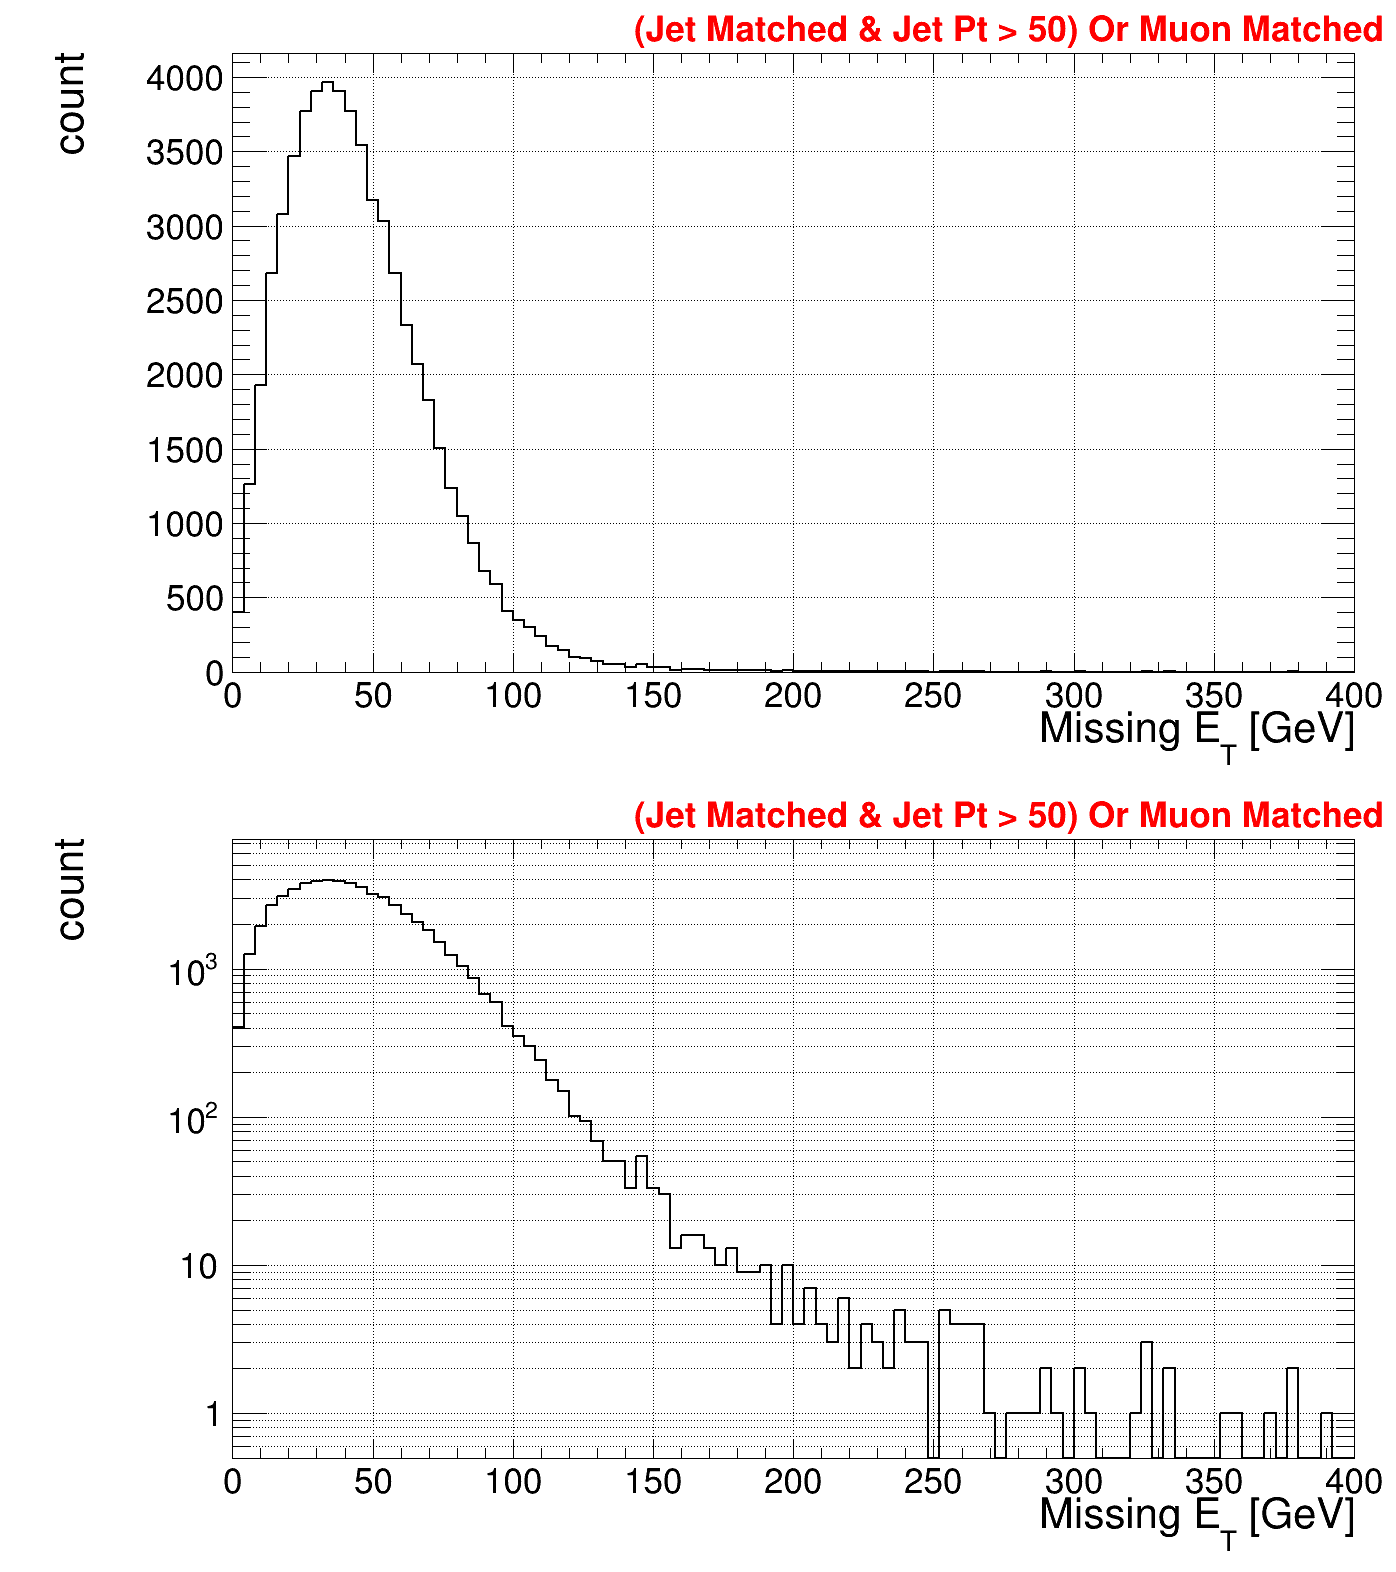

In [11]:
c = canvas(2, 1, width=1 * 1400, height=2 * 800)

x = D["met"]
bs = [100, 0, 400]
###
c.cd(1)
h1 = create_TH1D(x, "met", ";Missing E_{T} [GeV];count", bs)
h1.Draw()

lat.DrawLatexNDC(1, 1, cut_comment)

c.cd(2).SetLogy()
h2 = create_TH1D(x, "met", ";Missing E_{T} [GeV];count", bs)
h2.Draw()

lat.DrawLatexNDC(1, 1, cut_comment)
c.Print(out_dir + "met" + file_comment)

In [ ]:
c = canvas(1, 1)

x_csc = D["cscRechitClusterTimeWeighted"]
x_dt = D["dtRechitClusterTimeWeighted"]
title = ";Cluster Size;count"
bs = [100, -20, 20]

leg = rt.TLegend(0.6, 0.7, 0.9, 0.85)
leg.SetTextSize(0.025)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
###
c.cd(1)
for i, (x, tt, cc) in enumerate(zip((x_csc, x_dt), ("CSC", "DT"), std_color_list)):
    x = ak.flatten(x)
    h1 = create_TH1D(x, "time", title, bs)
    h1.SetLineColor(std_color_list[i])
    h1.Draw("same")
    leg.AddEntry(h1, tt, "L")
    gc.append(h1)

leg.Draw()

lat.DrawLatexNDC(1, 1, cut_comment)
c.Print(out_dir + "size" + file_comment)

/home/psimmerl/mambaforge/envs/rtenv/lib/python3.10/site-packages/root_numpy/_hist.py:75: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return _librootnumpy.fill_h1(
/home/psimmerl/mambaforge/envs/rtenv/lib/python3.10/site-packages/root_numpy/_hist.py:75: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review 

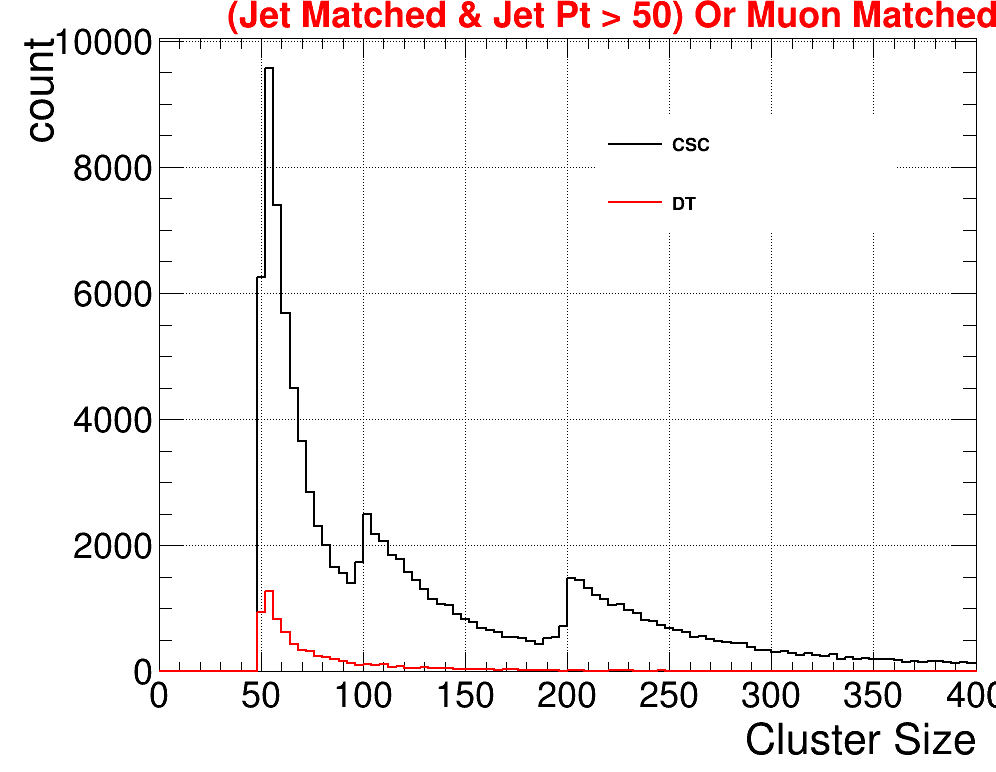

In [12]:
c = canvas(1, 1)

x_csc = D["cscRechitClusterSize"]
x_dt = D["dtRechitClusterSize"]
title = ";Cluster Size;count"
bs = [100, 0, 400]

leg = rt.TLegend(0.6, 0.7, 0.9, 0.85)
leg.SetTextSize(0.025)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
###
c.cd(1)
for i, (x, tt, cc) in enumerate(zip((x_csc, x_dt), ("CSC", "DT"), std_color_list)):
    x = ak.flatten(x)
    h1 = create_TH1D(x, "met", title, bs)
    h1.SetLineColor(std_color_list[i])
    h1.Draw("same")
    leg.AddEntry(h1, tt, "L")
    gc.append(h1)

leg.Draw()

lat.DrawLatexNDC(1, 1, cut_comment)
c.Print(out_dir + "size" + file_comment)

/home/psimmerl/mambaforge/envs/rtenv/lib/python3.10/site-packages/root_numpy/_hist.py:70: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return _librootnumpy.fill_h2(
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /home/psimmerl/Documents/CMS/LLP/reports/weekly/feb12/ncsc_ndt_fail_jet_muon_match.png has been created


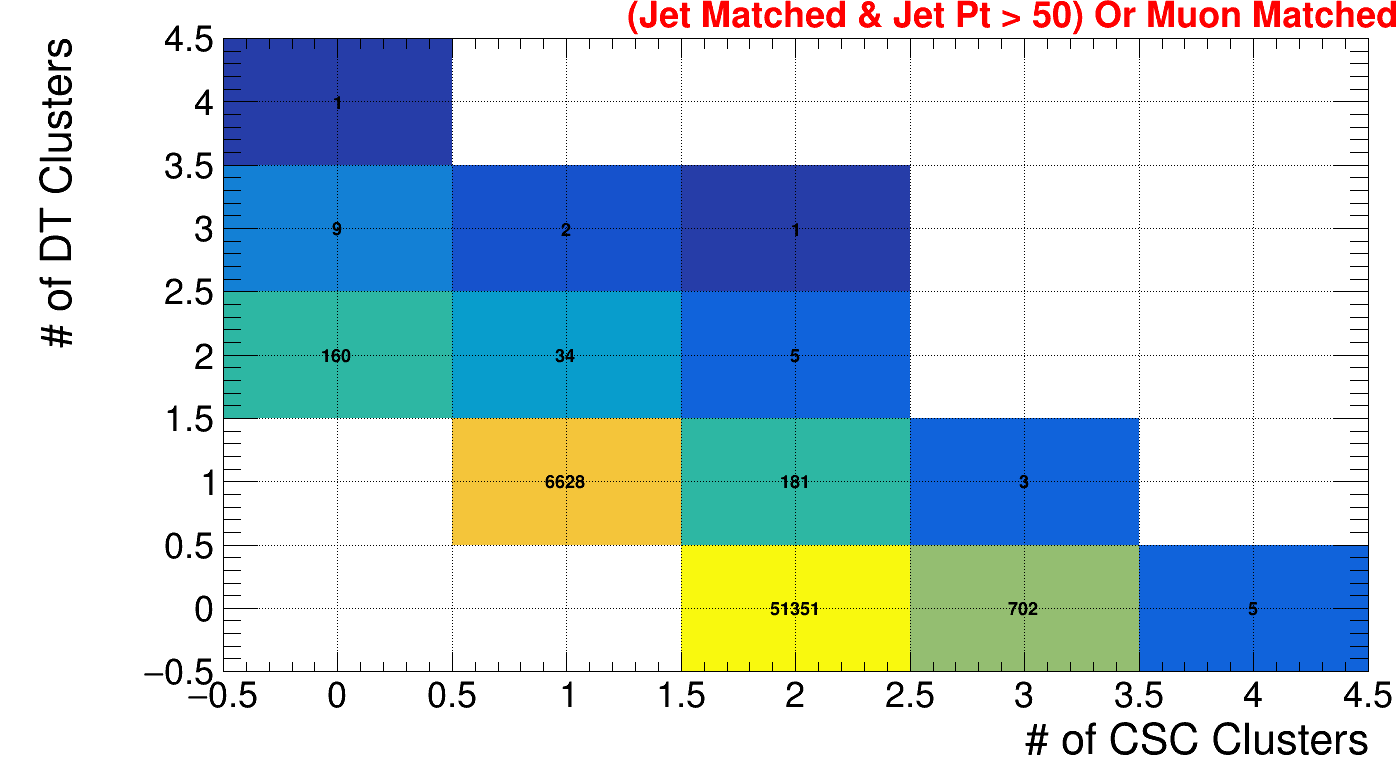

In [13]:
c = canvas(1, 1, width=1 * 1400, height=1 * 800)
rt.gStyle.SetPaintTextFormat(".0f")  # .2G')

###
c.cd(1).SetLogz()
x, y = D["nCscRechitClusters"], D["nDtRechitClusters"]
bs, xy = [int(np.max(x) + 1), -0.5, np.max(x) + 0.5, int(np.max(y) + 1), -0.5, np.max(y) + 0.5], np.c_[x, y]
h1 = create_TH2D(xy, "ncsc_ndt", ";# of CSC Clusters;# of DT Clusters;", bs)
h1.SetMarkerSize(1.3)
h1.Draw("coltext")

lat.DrawLatexNDC(1, 1, cut_comment)
c.Print(out_dir + "ncsc_ndt" + file_comment)

/home/psimmerl/mambaforge/envs/rtenv/lib/python3.10/site-packages/root_numpy/_hist.py:70: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return _librootnumpy.fill_h2(
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: ncsc_ndt (Potential memory leak).
Info in <TCanvas::Print>: png file /home/psimmerl/Documents/CMS/LLP/reports/weekly/feb12/ncsc_ndt_frac_fail_jet_muon_match.png has been created


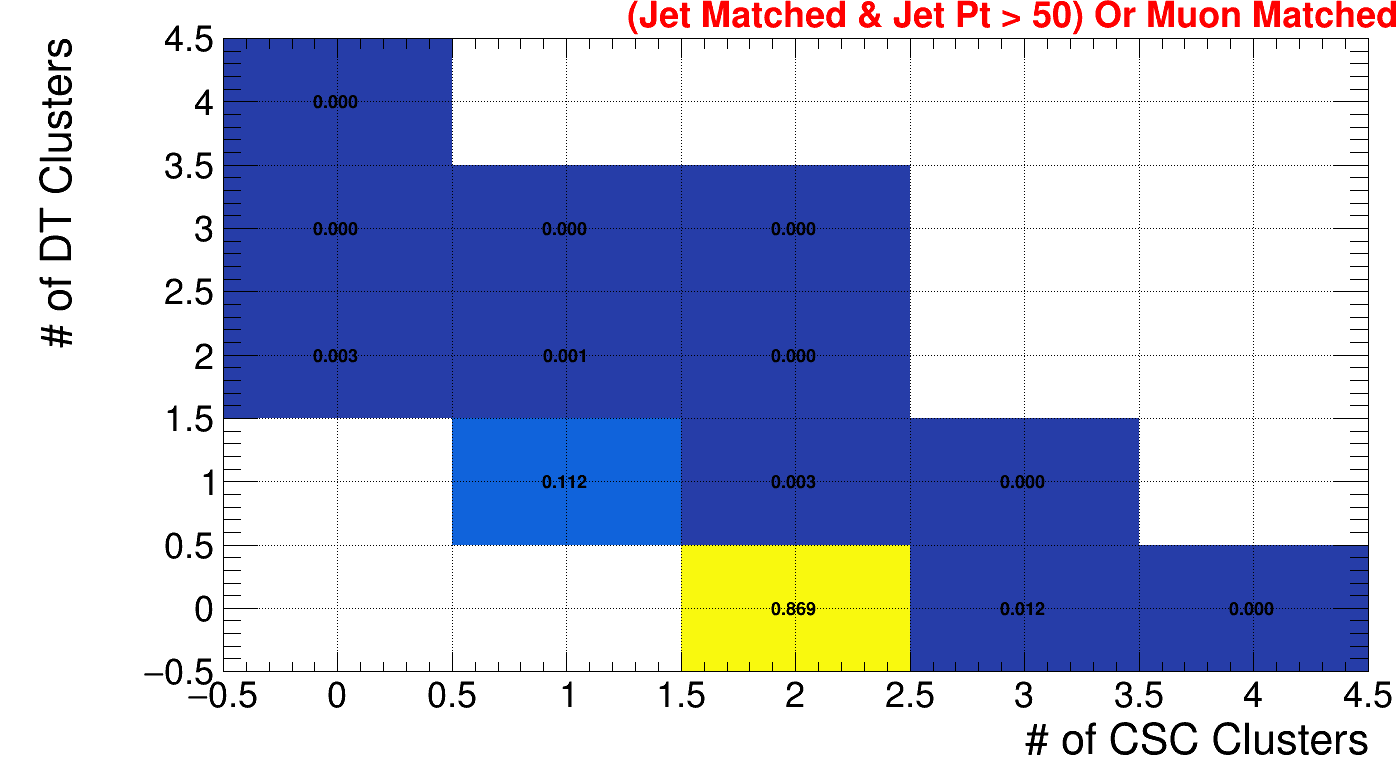

In [14]:
c = canvas(1, 1, width=1 * 1400, height=1 * 800)
rt.gStyle.SetPaintTextFormat(".3f")  # .2G')
###
c.cd(2)
x, y = D["nCscRechitClusters"], D["nDtRechitClusters"]
bs, xy = [int(np.max(x) + 1), -0.5, np.max(x) + 0.5, int(np.max(y) + 1), -0.5, np.max(y) + 0.5], np.c_[x, y]
h2 = create_TH2D(xy, "ncsc_ndt", ";# of CSC Clusters;# of DT Clusters;", bs, D["weight"] / np.sum(D["weight"]))
h2.SetMarkerSize(1.3)
h2.Draw("coltext")

lat.DrawLatexNDC(1, 1, cut_comment)

c.Print(out_dir + "ncsc_ndt_frac" + file_comment)

/home/psimmerl/mambaforge/envs/rtenv/lib/python3.10/site-packages/root_numpy/_hist.py:70: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return _librootnumpy.fill_h2(
/home/psimmerl/mambaforge/envs/rtenv/lib/python3.10/site-packages/root_numpy/_hist.py:70: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review 

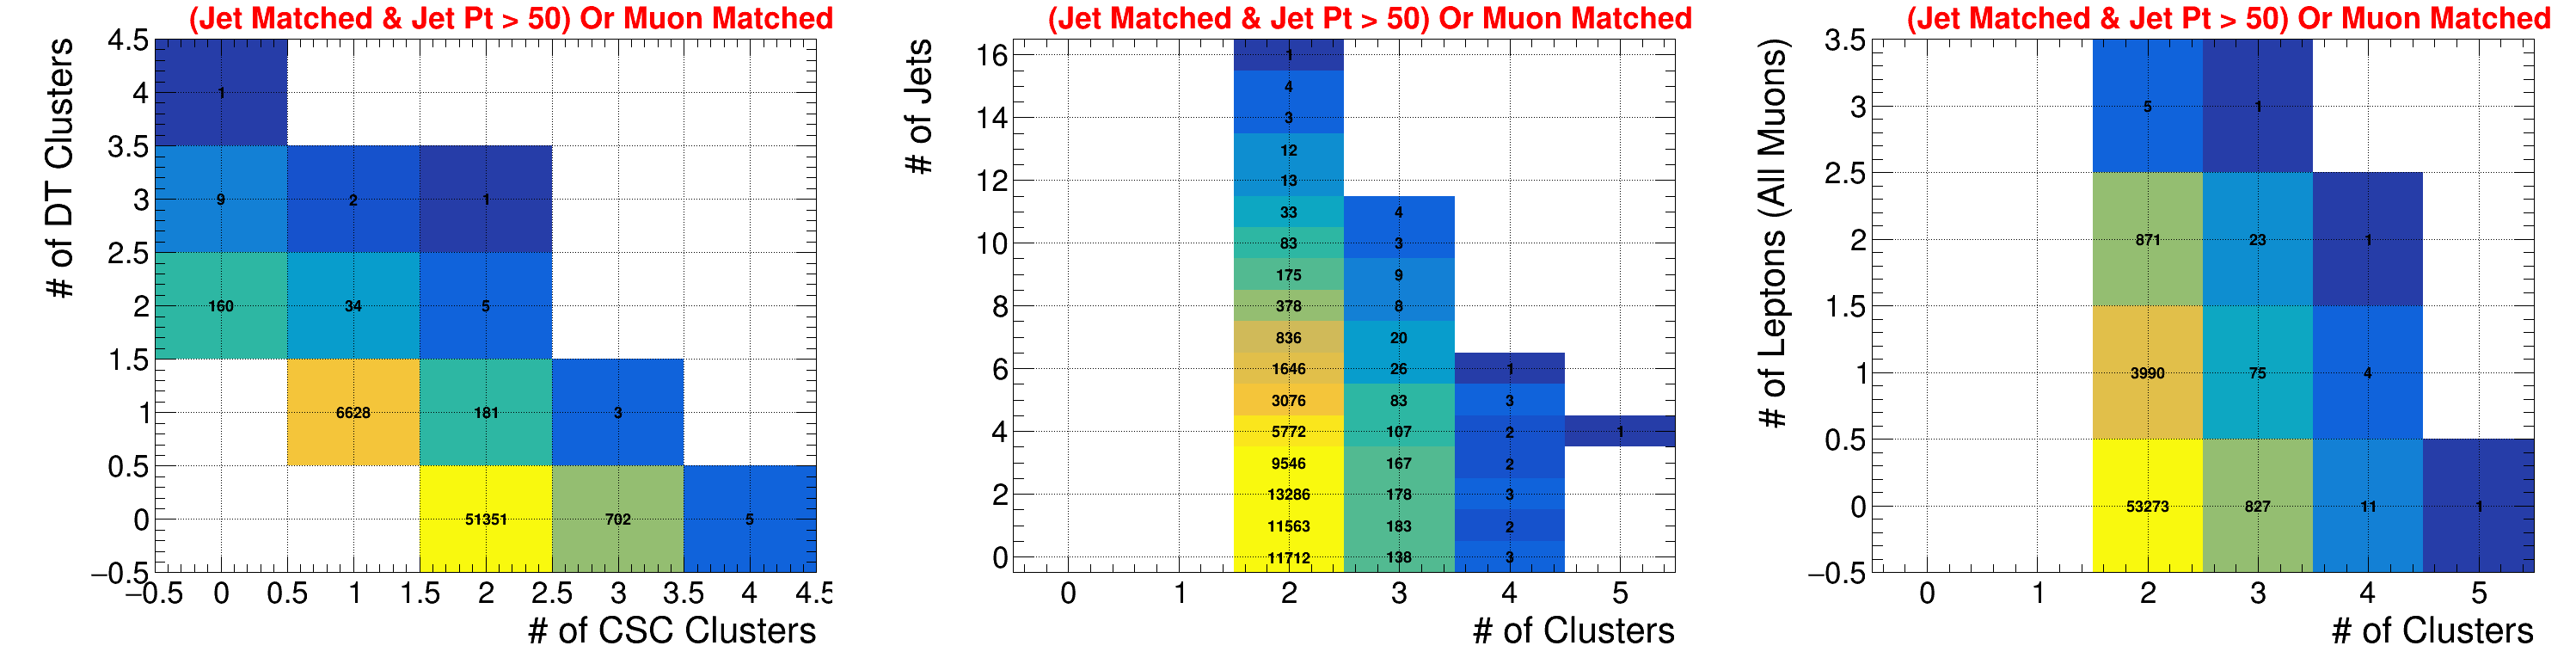

In [15]:
c = canvas(1, 3)  #
rt.gStyle.SetPaintTextFormat(".0f")  # .2G')
###
c.cd(1).SetLogz()
x, y = D["nCscRechitClusters"], D["nDtRechitClusters"]
bs, xy = [int(np.max(x) + 1), -0.5, np.max(x) + 0.5, int(np.max(y) + 1), -0.5, np.max(y) + 0.5], np.c_[x, y]
h1 = create_TH2D(xy, "ncsc_ndt", ";# of CSC Clusters;# of DT Clusters;", bs)
h1.SetMarkerSize(1.3)
h1.Draw("coltext")

lat.DrawLatexNDC(1, 1, cut_comment)

###
c.cd(2).SetLogz()
x, y = D["nCscRechitClusters"] + D["nDtRechitClusters"], D["nJets"]
bs, xy = [int(np.max(x) + 1), -0.5, np.max(x) + 0.5, int(np.max(y) + 1), -0.5, np.max(y) + 0.5], np.c_[x, y]
h2 = create_TH2D(xy, "ncluster_njets", ";# of Clusters;# of Jets;", bs)
h2.SetMarkerSize(1.3)
h2.Draw("coltext")

lat.DrawLatexNDC(1, 1, cut_comment)

###
c.cd(3).SetLogz()
x, y = D["nCscRechitClusters"] + D["nDtRechitClusters"], D["nLeptons"]
bs, xy = [int(np.max(x) + 1), -0.5, np.max(x) + 0.5, int(np.max(y) + 1), -0.5, np.max(y) + 0.5], np.c_[x, y]
h3 = create_TH2D(xy, "ncluster_nleps", ";# of Clusters;# of Leptons (All Muons);", bs)
h3.SetMarkerSize(1.3)
h3.Draw("coltext")

lat.DrawLatexNDC(1, 1, cut_comment)

###

c.Print(out_dir + "clusters_multi" + file_comment)

/home/psimmerl/mambaforge/envs/rtenv/lib/python3.10/site-packages/root_numpy/_hist.py:70: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return _librootnumpy.fill_h2(
/home/psimmerl/mambaforge/envs/rtenv/lib/python3.10/site-packages/root_numpy/_hist.py:70: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review 

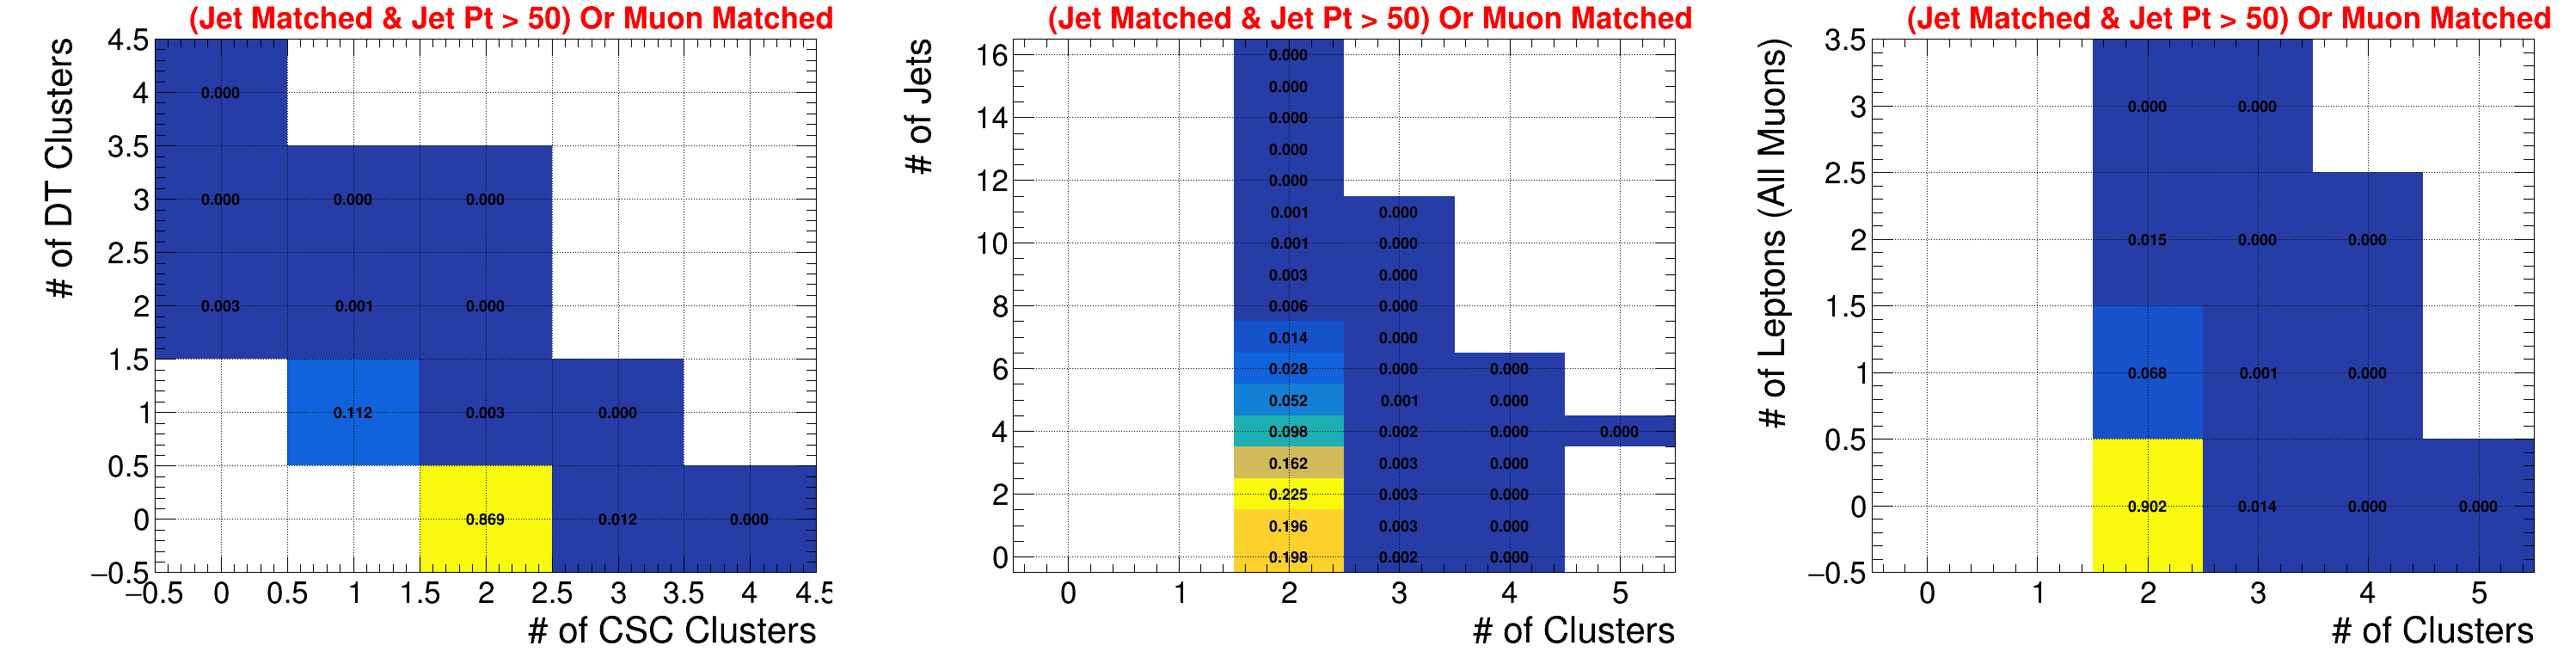

In [16]:
c = canvas(1, 3)  # , width=2*800,height=1*800)
rt.gStyle.SetPaintTextFormat(".3f")  # .2G')

###
c.cd(1)  # .SetLogz()
x, y = D["nCscRechitClusters"], D["nDtRechitClusters"]
bs, xy = [int(np.max(x) + 1), -0.5, np.max(x) + 0.5, int(np.max(y) + 1), -0.5, np.max(y) + 0.5], np.c_[x, y]
h1 = create_TH2D(xy, "ncsc_ndt", ";# of CSC Clusters;# of DT Clusters;", bs, D["weight"] / np.sum(D["weight"]))
h1.SetMarkerSize(1.3)
h1.Draw("coltext")

lat.DrawLatexNDC(1, 1, cut_comment)

###
c.cd(2)  # .SetLogz()
x, y = D["nCscRechitClusters"] + D["nDtRechitClusters"], D["nJets"]
bs, xy = [int(np.max(x) + 1), -0.5, np.max(x) + 0.5, int(np.max(y) + 1), -0.5, np.max(y) + 0.5], np.c_[x, y]
h2 = create_TH2D(xy, "ncluster_njets", ";# of Clusters;# of Jets;", bs, D["weight"] / np.sum(D["weight"]))
h2.SetMarkerSize(1.3)
h2.Draw("coltext")

lat.DrawLatexNDC(1, 1, cut_comment)

###
c.cd(3)  # .SetLogz()
x, y = D["nCscRechitClusters"] + D["nDtRechitClusters"], D["nLeptons"]
bs, xy = [int(np.max(x) + 1), -0.5, np.max(x) + 0.5, int(np.max(y) + 1), -0.5, np.max(y) + 0.5], np.c_[x, y]
h3 = create_TH2D(
    xy, "ncluster_nleps", ";# of Clusters;# of Leptons (All Muons);", bs, D["weight"] / np.sum(D["weight"])
)
h3.SetMarkerSize(1.3)
h3.Draw("coltext")

lat.DrawLatexNDC(1, 1, cut_comment)

###

c.Print(out_dir + "clusters_multi_normed" + file_comment)

In [17]:
# 1D Cluster size CSC
# 1D Cluster size DT
# Both with MET cut

In [18]:
# mass, ctaus = ['15'], ['1000']
# plot_ctaus = ['10', '100', '200', '500', '700', '1000', '2000', '5000', '10000', '50000', '100000', '1000000']

# sel_dt = land(data['gLLP_decay_vertex_abs_z'] < 661, data['gLLP_decay_vertex_abs_r'] > 380,
#                 data['gLLP_decay_vertex_r'] < 738)

# sel_csc = land(data['gLLP_abs_eta'] < 2.4, data['gLLP_decay_vertex_abs_r'] < 695.5,
#                 data['gLLP_decay_vertex_z'] < 1100, data['gLLP_decay_vertex_abs_z'] > 661)

# me11 = land(data['gLLP_abs_eta'] < 2.4, data['gLLP_decay_vertex_abs_r'] < 270, data['gLLP_decay_vertex_abs_z'] < 661,
#             data['gLLP_decay_vertex_abs_z'] > 500)

# sel_csc = lor(sel_csc, me11)  # definition to make sure no overlap, BUG?
# sel_ev_cross = land(np.sum(sel_csc, axis=1) == 1, np.sum(sel_dt, axis=1) == 1)
# sel_ev_csc2 = np.sum(sel_csc, axis=1) == 2
# sel_ev_dt2 = np.sum(sel_dt, axis=1) == 2
# sel_ev_csc1 = np.sum(sel_csc, axis=1) >= 1
# sel_ev_dt1 = np.sum(sel_dt, axis=1) >= 1
# sel_ev_2tag = lor(sel_ev_cross, sel_ev_csc2, sel_ev_dt2)

# acceptance_dt1 = np.sum(data['weight'][sel_ev_dt1]) / np.sum(data['weight'])
# acceptance_csc1 = np.sum(data['weight'][sel_ev_csc1]) / np.sum(data['weight'])
# acceptance_dt2 = np.sum(data['weight'][sel_ev_dt2]) / np.sum(data['weight'])
# acceptance_csc2 = np.sum(data['weight'][sel_ev_csc2]) / np.sum(data['weight'])
# acceptance_cross = np.sum(data['weight'][sel_ev_cross]) / np.sum(data['weight'])

# acceptance_2tag = acceptance_dt2 + acceptance_csc2 + acceptance_cross

# sel_ev = data['met'] > 200  #np.sum(data['HLTDecision'][:, 562:771],
# # axis=1)  #  #(data['metEENoise'] >= 200), (data['METNoMuTrigger'])
# # sel_ev = data['HLTDecision']  #(data['metEENoise'] >= 200), (data['METNoMuTrigger'])

# accep_met_dt1 = np.sum(data['weight'][land(sel_ev, sel_ev_dt1)]) / np.sum(data['weight'])
# accep_met_csc1 = np.sum(data['weight'][land(sel_ev, sel_ev_csc1)]) / np.sum(data['weight'])
# accep_met_dt2 = np.sum(data['weight'][land(sel_ev, sel_ev_dt2)]) / np.sum(data['weight'])
# accep_met_csc2 = np.sum(data['weight'][land(sel_ev, sel_ev_csc2)]) / np.sum(data['weight'])
# accep_met_cross = np.sum(data['weight'][land(sel_ev, sel_ev_cross)]) / np.sum(data['weight'])

# accep_met_2tag = accep_met_dt2 + accep_met_csc2 + accep_met_cross